In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix

from yellowbrick.classifier import ROCAUC

from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load all sklearn models
with open("./models/all_sklearn.pkl", "rb") as f:
    sklearn_models = pickle.load(f)

# Load all deep learning models
three_model = load_model("C:/Users/Alrowad/Exercise-correction/plank_model/models/3_layers.h5")
five_model = load_model("C:/Users/Alrowad/Exercise-correction/plank_model/models/5_layers.h5")
seven_model = load_model("C:/Users/Alrowad/Exercise-correction/plank_model/models/7_layers.h5")
sevenD_model = load_model("C:/Users/Alrowad/Exercise-correction/plank_model/models/7_layers_with_dropout.h5")

# Load input scaler
with open("./models/input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)

In [3]:
def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

In [4]:
# load dataset
test_df = describe_dataset("./CSV_dataset/test.csv")

# Categorizing label
test_df.loc[test_df["label"] == "C", "label"] = 0
test_df.loc[test_df["label"] == "H", "label"] = 1
test_df.loc[test_df["label"] == "L", "label"] = 2

# Standard Scaling of features
test_x = test_df.drop("label", axis = 1)
test_x = pd.DataFrame(sc.transform(test_x))

test_y = test_df["label"].astype('int')

# # Converting prediction to categorical
test_y_cat = to_categorical(test_y)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

In [5]:
testset_final_results = []

for name, model in sklearn_models.items():
    # Evaluate model
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average="weighted")
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average="weighted")
    f1_score_result = f1_score(test_y, model_results, average="weighted")
    cm = confusion_matrix(test_y, model_results, labels=[0, 1, 2])
    testset_final_results.append(( name,  p_score, r_score, a_score, f1_score_result, cm ))


sklearn_eval = pd.DataFrame(testset_final_results, columns=["Model", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

sklearn_eval

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,LR,0.938190,0.937500,0.937500,0.937070,"[[151, 11, 10], [6, 203, 1], [1, 4, 141]]"
1,SVC,0.930560,0.929924,0.929924,0.930065,"[[158, 3, 11], [14, 195, 1], [3, 5, 138]]"
2,KNN,0.914391,0.912879,0.912879,0.912066,"[[143, 15, 14], [6, 201, 3], [3, 5, 138]]"
3,DTC,0.939587,0.939394,0.939394,0.939259,"[[156, 9, 7], [7, 202, 1], [2, 6, 138]]"
4,SGDC,0.919713,0.918561,0.918561,0.917969,"[[145, 9, 18], [9, 200, 1], [2, 4, 140]]"
5,NB,0.690043,0.676136,0.676136,0.680091,"[[96, 24, 52], [52, 152, 6], [34, 3, 109]]"
6,RF,0.954590,0.954545,0.954545,0.954425,"[[159, 5, 8], [5, 205, 0], [2, 4, 140]]"


In [6]:
test_set_results = []

model_paths = ["./models/3_layers.h5", 
               "./models/5_layers.h5", 
               "./models/7_layers.h5", 
               "./models/7_layers_with_dropout.h5"]

for path in model_paths:
    model = load_model(path)

    # Evaluate model
    predict_x = model.predict(test_x, verbose=False) 
    y_pred_class = np.argmax(predict_x, axis=1)
    y_test_class = np.argmax(test_y_cat, axis=1)

    cm = confusion_matrix(y_test_class, y_pred_class, labels=[0, 1, 2])
    p_score = precision_score(y_test_class, y_pred_class, average="weighted")
    a_score = accuracy_score(y_test_class, y_pred_class)
    r_score = recall_score(y_test_class, y_pred_class, average="weighted")
    f1_score_result = f1_score(y_test_class, y_pred_class, average="weighted")
    
    test_set_results.append(( path,  p_score, r_score, a_score, f1_score_result, cm ))

dp_eval = pd.DataFrame(test_set_results, columns=["Model Path", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

dp_eval

,Model Path,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,./models/3_layers.h5,0.949544,0.948864,0.948864,0.948575,"[[155, 11, 6], [3, 207, 0], [3, 4, 139]]"
1,./models/5_layers.h5,0.936482,0.935606,0.935606,0.935282,"[[151, 7, 14], [7, 202, 1], [1, 4, 141]]"
2,./models/7_layers.h5,0.951214,0.950758,0.950758,0.950668,"[[157, 3, 12], [6, 204, 0], [1, 4, 141]]"
3,./models/7_layers_with_dropout.h5,0.962208,0.962121,0.962121,0.962145,"[[165, 2, 5], [8, 202, 0], [1, 4, 141]]"


In [7]:
eval_df = pd.concat([sklearn_eval, dp_eval])
eval_df = eval_df.sort_values(by=['F1 Score'], ascending=False).reset_index(drop=True)
eval_df.to_csv(f"evaluation.csv", sep=',', encoding='utf-8', index=False)
eval_df

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix,Model Path
0,NaN,0.962208,0.962121,0.962121,0.962145,"[[165, 2, 5], [8, 202, 0], [1, 4, 141]]",./models/7_layers_with_dropout.h5
1,RF,0.954590,0.954545,0.954545,0.954425,"[[159, 5, 8], [5, 205, 0], [2, 4, 140]]",NaN
2,NaN,0.951214,0.950758,0.950758,0.950668,"[[157, 3, 12], [6, 204, 0], [1, 4, 141]]",./models/7_layers.h5
3,NaN,0.949544,0.948864,0.948864,0.948575,"[[155, 11, 6], [3, 207, 0], [3, 4, 139]]",./models/3_layers.h5
4,DTC,0.939587,0.939394,0.939394,0.939259,"[[156, 9, 7], [7, 202, 1], [2, 6, 138]]",NaN
5,LR,0.938190,0.937500,0.937500,0.937070,"[[151, 11, 10], [6, 203, 1], [1, 4, 141]]",NaN
6,NaN,0.936482,0.935606,0.935606,0.935282,"[[151, 7, 14], [7, 202, 1], [1, 4, 141]]",./models/5_layers.h5
7,SVC,0.930560,0.929924,0.929924,0.930065,"[[158, 3, 11], [14, 195, 1], [3, 5, 138]]",NaN
8,SGDC,0.919713,0.918561,0.918561,0.917969,"[[145, 9, 18], [9, 200, 1], [2, 4, 140]]",NaN
9,KNN,0.914391,0.912879,0.912879,0.912066,"[[143, 15, 14], [6, 201, 3], [3, 5, 138]]",NaN


In [8]:
best_model = sklearn_models["RF"]
y_predictions = best_model.predict(test_x)

p_score = precision_score(test_y, y_predictions, labels=[0, 1, 2], average=None)
r_score = recall_score(test_y, y_predictions, labels=[0, 1, 2], average=None)
f1_score_result = f1_score(test_y, y_predictions, labels=[0, 1, 2], average=None)

p_score, r_score, f1_score_result

(array([0.95783133, 0.95794393, 0.94594595]),
 array([0.9244186 , 0.97619048, 0.95890411]),
 array([0.9408284 , 0.96698113, 0.95238095]))

In [9]:
best_model01 = sevenD_model
y_predictions = best_model01.predict(test_x)

# convert continuous values to discrete labels using a threshold of 0.5
y_predictions_labels = (y_predictions >= 0.5).argmax(axis=-1)

p_score = precision_score(test_y, y_predictions_labels, labels=[0, 1, 2], average=None)
r_score = recall_score(test_y, y_predictions_labels, labels=[0, 1, 2], average=None)
f1_score_result = f1_score(test_y, y_predictions_labels, labels=[0, 1, 2], average=None)

p_score, r_score, f1_score_result

17/17 [==============================] - 0s 2ms/step


(array([0.94827586, 0.97115385, 0.96575342]),
 array([0.95930233, 0.96190476, 0.96575342]),
 array([0.95375723, 0.96650718, 0.96575342]))

In [10]:
(0.941 + 0.967 + 0.952) / 3

0.9533333333333333

In [11]:
(0.954 + 0.967 + 0.966) / 3

0.9623333333333332

<AxesSubplot:>

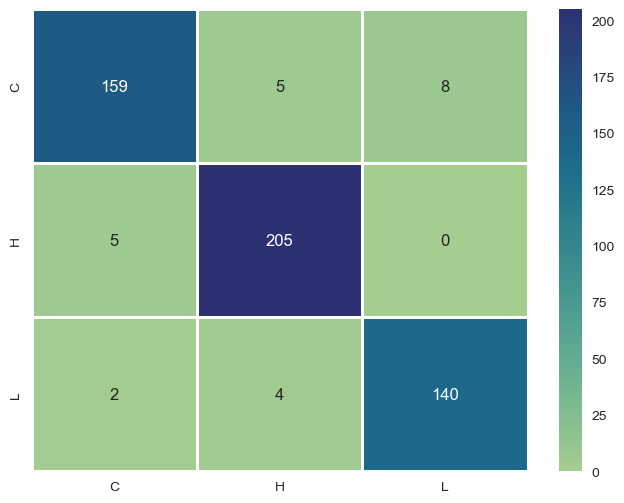

In [12]:
KNN_cm = eval_df[ eval_df["Model"] == 'RF' ]["Confusion Matrix"].values[0]

cm_array_df = pd.DataFrame(KNN_cm, index=["C", "H", "L"], columns=["C", "H", "L"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(cm_array_df, linewidths=1, annot=True, ax=ax, fmt='g', cmap="crest")

<AxesSubplot:>

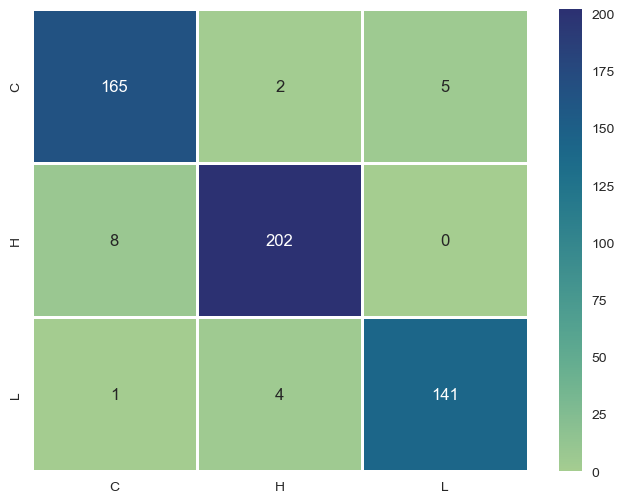

In [13]:
DL_cm = eval_df[ eval_df["Model Path"] == './models/7_layers_with_dropout.h5' ]["Confusion Matrix"].values[0]

cm_array_df = pd.DataFrame(DL_cm, index=["C", "H", "L"], columns=["C", "H", "L"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(cm_array_df, linewidths=1, annot=True, ax=ax, fmt='g', cmap="crest")

In [14]:
def to_labels(y_pred, y_pred_proba, threshold):
    '''Return prediction taking confidence threshold into account'''
    results = []

    for index, predicted_class in enumerate(y_pred):
        prediction_probabilities = y_pred_proba[index]
        class_prediction_probability = round(prediction_probabilities[np.argmax(prediction_probabilities)], 2)

        results.append(predicted_class if class_prediction_probability >= threshold else -1)
    
    return results


def calculate_correlation_score_confidence(test_x, test_y):
    '''Calculate correlation between Precision score/Recall score/F1 score and confidence threshold'''
    y_predictions = best_model.predict(test_x)
    y_predict_proba = best_model.predict_proba(test_x)

    thresholds = list(np.arange(0, 1.01, 0.01))

    f1_score_results = []

    for threshold in thresholds:
        true_predictions = to_labels(y_predictions, y_predict_proba, threshold)
        f1_s = list(f1_score(test_y, true_predictions, labels=[0, 1, 2], average=None))
        all_class_f1 = f1_score(test_y, true_predictions, labels=[0, 1, 2], average="weighted")
        f1_s.append(all_class_f1)
        f1_score_results.append(f1_s)
    
    return thresholds, f1_score_results

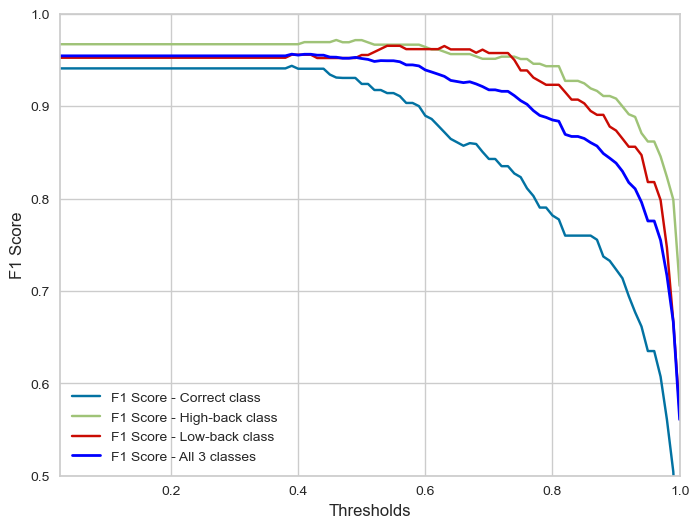

In [15]:
thresholds, f1_scores = calculate_correlation_score_confidence(test_x, test_y)

first_class = [ el[0] for el in f1_scores ]
second_class = [ el[1] for el in f1_scores ]
third_class = [ el[2] for el in f1_scores ]
all_classes = [ el[3] for el in f1_scores ]


fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, first_class, label = "F1 Score - Correct class")
plt.plot(thresholds, second_class, label = "F1 Score - High-back class")
plt.plot(thresholds, third_class, label = "F1 Score - Low-back class")
plt.plot(thresholds, all_classes, label = "F1 Score - All 3 classes", linewidth=2.0, color="blue")
plt.legend(loc = 'lower left')
plt.ylim([0.5, 1])
plt.xlim([0.025, 1])
plt.xlabel("Thresholds", fontsize = 12)
plt.ylabel("F1 Score", fontsize = 12)
plt.show()

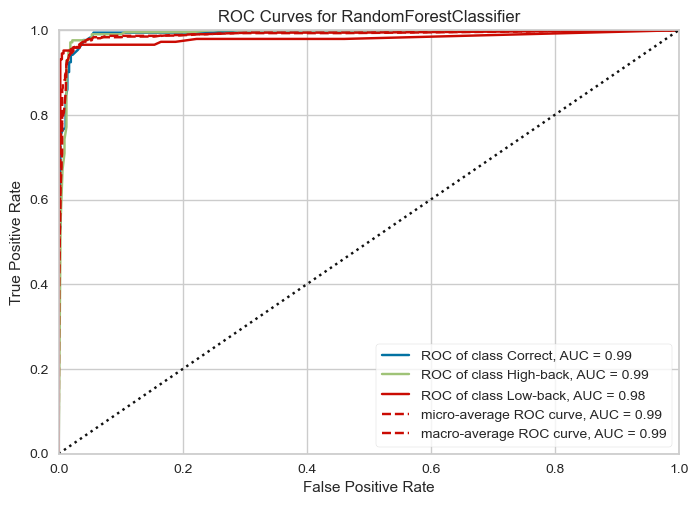

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [16]:
visualizer = ROCAUC(best_model, classes=["Correct", "High-back", "Low-back"])
visualizer.target_type_ = "multiclass"
visualizer.score(test_x, test_y)        
visualizer.show()       